# Калибровка вероятности дефолта

Для принятия решения важно не только учметь разделять между собой "хороших" клиентов от "плохих", но и достаточно точно прогнозировать вероятность наступления дефолта. Когда качество разделения модели достаточно сильное, но попадание в реальные риски плохое, можно производить калибровку - несложное преобразование прогноза вероятности дефолта. Данная задача также часто возникает, когда появляется новый продукт или новый сегмент слабо представленный в обучающей выборке, и  возможность перестраивания модели отсутствует.

В данном ноутбуке мы рассмотрим несколько подходов к калибровки модели.

Загрузим сначала выборку с данными.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

url_calibration = 'https://www.dropbox.com/s/a5tlpq8njxg5d33/calibration.csv?dl=1'
df = pd.read_csv(url_calibration)
df.head() 
# pd - то, что предсказали
# default_flg - правильный ответ
# что category_feature значит

,pd,default_flg,category_feature
0,0.108868,0,E
1,0.146724,0,E
2,0.094514,0,E
3,0.092973,0,C
4,0.265591,1,E


In [2]:
df.shape

(30000, 3)

В данной выборке присутствует 30000 наблюдений, и три поля.

# Визуализация качества прогноза

Выборка разбивается на равные по количеству бакеты в зависимости от значения прогноза. В каждом бакете считается средний прогноз и частота наступления дефолта.

In [22]:
def plot_gain_chart(target, prob, num_buck=10):    
    data = pd.DataFrame({'target': target, 'predict': prob})
    # qcut делит всю выборку на num_buck квантилей и присваивает каждому объекту значение номера квантили, 
    # в которую он попадает
    buckets = pd.qcut(prob, q=num_buck)
    # mean для квантили i - среднее значение по всем объектам из квантили i (целевой переменной и самого объекта)
    aggregated = data.groupby(buckets).agg({'target': 'mean', 'predict': 'mean'})
    aggregated = aggregated.sort_index(ascending=False).reset_index(drop=True)
    aggregated.plot(kind='bar', grid=True)
#    return aggregated

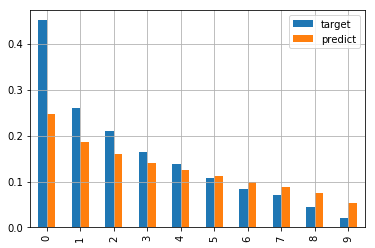

In [23]:
plot_gain_chart(df['default_flg'], df['pd'])

По данной диаграмме видно, что среди бакетов [0, 1, 2] реальная частота дефолтов оказывается выше, чем средний прогноз.  

К массиву `df['pd']` можно применять арифметические преобразования, которые применяются поэлементно.

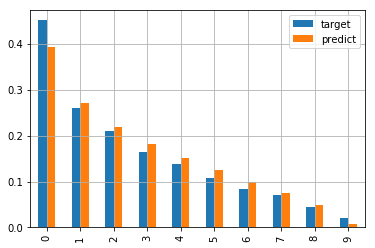

In [24]:
plot_gain_chart(df['default_flg'], 2 * df['pd'] - 0.1)

Так же можно применять и любые преобразования из из numpy, которые так же поэлементные. Например, `np.exp()` или `np.sin()`.

# Калибровка логистической регрессией

В логистической регрессии присутствует сигмоидное преобразование $\sigma(x) = \frac{1}{1+exp(-x)}$.  

**Задание. Напишите функцию логистического преобразования, которое является обратным к сигмоидному.**

In [30]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [49]:
# функция, обратная к сигмоидной
def logit(x):    
    y = -np.log((1-x)/x)
    return y    

In [57]:
sigmoid(pd.Series([2]))

0.8807970779778823

In [60]:
logit(pd.Series(sigmoid(pd.Series([2]))))

0    2.0
dtype: float64

Создадим новый столбец `logit` в таблице

In [61]:
df['logit'] = logit(df['pd'])

In [62]:
df.head()

,pd,default_flg,category_feature,logit
0,0.108868,0,E,-2.102354
1,0.146724,0,E,-1.760528
2,0.094514,0,E,-2.259719
3,0.092973,0,C,-2.277865
4,0.265591,1,E,-1.017110


**Задание. Нарисуйте теперь диаграмму рассеивания между `logit` и `pd`. Точки должны лечь на часть сигмоиды.**

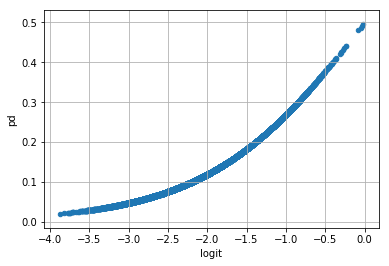

In [66]:
df.plot(x='logit', y='pd', kind='scatter', grid=True);

Произведем калибровку, обучив логистическую регрессию на одном признаке `df['logit']`.  
В scikit-learn алгоритм машинного обучения выглядят следующим образом:

In [67]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()                                      # Определяем объект - классификатор
classifier.fit( df[['logit']], df['default_flg'] );                    # Производим обучение, вызвав метод fit

После обучения (запуска метода `.fit()`), у обекта `classifier` появляются атрибуты с коэффициентами

In [68]:
classifier.intercept_  # свободный член

array([1.99754727])

In [69]:
classifier.coef_       # коэффициенты перед признаками, в нашем случае всего одно число, так как признак один

array([[1.99923055]])

Посмотрим как теперь выглядит график gain chart.

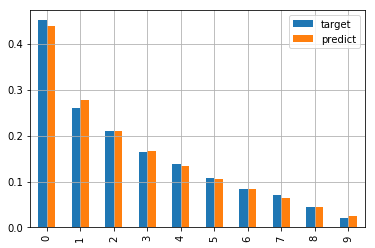

In [70]:
logistic_calibration = classifier.predict_proba(df[['logit']])[:, 1]

plot_gain_chart(df['default_flg'], logistic_calibration)

Столбики с прогнозом и с частотой дефолтов стали гораздо ближе.  
Помимо визуализации полезно так же считать формальные метрики.  
**Задание. Сравните между собой по разным метрикам точность двух прогнозов. Объясните результаты.**

In [71]:
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

metrics = pd.DataFrame()  # можно создавать пустую таблицу, заполняя её позже

def add_metrics(metrics, target, predict, name):
    # для обращения к ячейкам есть метод .loc[название строки, название столбца]
    metrics.loc[name, 'MSE'     ] = mean_squared_error (target, predict)
    metrics.loc[name, 'AUC'     ] = roc_auc_score      (target, predict)
    metrics.loc[name, 'log_loss'] = log_loss           (target, predict)

add_metrics(metrics, df['default_flg'], df['pd'], 'pd')

add_metrics(metrics, df['default_flg'], logistic_calibration, 'logistic_calibration')

metrics

,MSE,AUC,log_loss
pd,0.121001,0.746103,0.392546
logistic_calibration,0.115498,0.746103,0.376995


**Задание. Посчитать метрики для тестовой выборки**

In [76]:
metrics_test = pd.DataFrame()

url_calibration_test = 'https://www.dropbox.com/s/s7bpm3tbzhqtvau/calibration_test.csv?dl=1'
df_test = pd.read_csv(url_calibration_test)

df_test['logit'] = logit(df_test['pd'])
logistic_calibration_test = classifier.predict_proba(df_test[['logit']])[:, 1]

add_metrics(metrics_test, df_test['default_flg'], df_test['pd'], 'pd')

add_metrics(metrics_test, df_test['default_flg'], logistic_calibration_test, 'logistic_calibration')

metrics_test

,MSE,AUC,log_loss
pd,0.120079,0.74249,0.390851
logistic_calibration,0.115102,0.74249,0.377082


# Калибровка линейной регрессией

Воспользуемся теперь линейной регрессией.  
Интерфейс обучения модели практически такой же.  

In [86]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(df[['pd']], df['default_flg']);

**Задание. Посчитайте метрики для прогноза `pd_linear`. Обясните результаты.**

In [ ]:
# <вставить код>
metrics

In [ ]:
# <вставить код>
metrics_test

# Калибровка [Isotonic regression](http://scikit-learn.org/stable/modules/isotonic.html)

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_isotonic_regression_0011.png" width=500>

Логистическая и линейная регрессия находят зависимость между наборами признаков и целевой переменной, isotonic зависимость между всего одним признаком и целевой переменной. Но за-то поиск происходит в достаточно большом классе функций - все возможные монотонные преобразования.  

Из за наличия только одного признака в метод `.fit()` и `.predict()` нужно подавать одномерный массив с признаком, а не двумерную матрицу, как в прошлых моделях.

**Задание. Произведите калибровку isotonic regression и посчитайте метрики. Объясните результаты.**

In [ ]:
from sklearn.isotonic import IsotonicRegression
# <вставить код>
metrics

In [ ]:
# <вставить код> для тестовой выборки
metrics_test

# Калибровка по отдельным группам

В выборке присутствует поле `category_feature`. Попробуем построить модель с использованием двух признаков: категории и `logit`.

In [ ]:
import statsmodels.formula.api as smf

log_reg = smf.logit('default_flg ~ category_feature + logit', data=df).fit()
log_reg.summary2()

In [ ]:
add_metrics(metrics, df['default_flg'], log_reg.predict(df), 'category')
metrics

In [ ]:
add_metrics(metrics_test, df_test['default_flg'], log_reg.predict(df_test), 'category')
metrics_test

Теперь возьмем только статистически знначимые признаки

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices


y, X = dmatrices('default_flg ~ category_feature + logit', data=df, return_type='dataframe')
X = X.loc[:, log_reg.pvalues < 0.05]
log_reg_drop = sm.Logit(y, X).fit()

log_reg_drop.summary2()

In [ ]:
add_metrics(metrics, df['default_flg'], log_reg_drop.predict(X), 'category_part')
metrics

**Задание. посчитать качество на тестовой выборке**

In [ ]:
# <вставить код>
metrics_test

**Задание. Построить модель с формулой `default_flg ~ category_feature * logit`**

In [ ]:
# <вставить код>

Сравните метрики с предыдущими моделями. Объясните результаты.

# Ссылки
* [10 Minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
* [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) - книга на github по анализу данных в python.
* [scikit-learn](http://scikit-learn.org)
* [statsmodels](http://www.statsmodels.org)